## Group 04 :
* Conet Brieuc (11181800)
* Deside Guillaume (39731800)
* Loffet Alexandre (54701700)

<font size=6  color=#003366> <div style="text-align: center"> [LGBIO2050] - Medical Imaging <br><br> 
<div style="text-align: center"> MR Simulation and Region Growing  </font> <br><br><br>

<font size=5  color=#003366>
<div style="text-align: left"> Professors :   
<font size=4  color=#003366>
<div style="text-align: left"> Prof. G. Kerckhofs  
<div style="text-align: left"> Prof. J. Lee <br>
<div style="text-align: left"> Prof. B. Macq <br>
<div style="text-align: left"> Prof. F. Peeters
<font size=5  color=#003366>
    
<br> <br>
<div style="text-align: left"> Teaching assistants : 
<font size=4  color=#003366>
<div style="text-align: left"> Damien Dasnoy-Sumell (damien.dasnoy@uclouvain.be)<br> 
<div style="text-align: left">Estelle Loÿen (estelle.loyen@uclouvain.be)
<font size=5  color=#003366>
<div style="text-align: right"> 2021-2022 </div>
<br><br>
</font>

<font size=5 color=#009999> **1. Guidelines and Deliverables** </font> <br> <br>
   - This assignment is due on **November 25th**.
   - Copying code or answers from other groups (or from the internet) is strictly forbidden. Each source of inspiration must be clearly indicated.
   - The jupyter notebook containing the code and **detailed answers** to the questions must be delivered in an
archive (.zip folder) on Moodle. The answers have to be written in English.<br> <br>

<font size=5 color=#009999> **2. Context and objectives** </font> <br> <br>

The purpose of this challenge is to simulate an MRI scanner acquisition, and then to segment a lesion in the brain using a pair of MRI images, one in proton density contrast and one in T1 weighted contrast. The T1 image comes directly from the scanner and as you know, MRI scanner acquire data in the frequency space, so you will need to reconstruct the image using the frequency data. Once you have both images, you will segment the lesion on both using the region growing method and compute the intersection in order to get a better contour of the lesion. 

![FIGURE 1](imgs/ProtonDensity.png "Proton density image")
<br>
<center>Figure 1: Proton density image.</center>

<font size=5 color=#009999> **3. MR Simulation** </font> <br>
To understand exactly how magnetic resonance imaging works, we ask you to simulate the behavior of a MR scanner and to recreate an image based on your simulated signal. In order to do this, you will have to complete the following tasks:

Examine and understand the equations of the behavior of MR imaging (section 4.2 of the course notes).
In particular, look at the following equation:
 
\begin{equation}
S(k_x,k_y) = \int\int\rho(x,y)e^{-i2\pi(k_xx+k_yy)}dxdy\qquad(1)
\end{equation}

<div class="alert alert-info">
<b>QUESTION 1</b>  <br>
First, load the 2 image data and plot them. Then, implement a script simulating the equations of the behavior of the MR scanner for a spin echo pulse sequence. In such sequences, $Gy = m∆Gy$ with $m ∈ \mathbb{Z}$. Knowing that the FOV (W) is of 256 mm in $x$ and $y$ and that the pixel resolution is of 1 mm, choose the parameters of the MR equipment $(γ, Gx,∆Gy, ∆t, Ty$ --> see hints here under) to be consistent with equations [4.41] and [4.42] of the notes. Using equation (1), you can now compute the matrix $S(k_x,k_y)$ taking the proton density image as $ρ(x, y)$ to simulate a real patient in an MRI scanner. Since you have all discrete values, the integration can actually be computed as a sum for all $x$ and $y$ values. What do $k_x$ and $k_y$ correspond to?
<br><br>
Hints: 
- Gradient amplitude are of the order of 10mT/m (for Gy and Gx) 
- Ty --> order of milliseconds 
- dt --> order of microseconds
</div>

# Question 1:

$k_x$ corresponds to the frequency and can be calculate thanks to the following equation : $k_x$ = γ Gx t
In similar way, $k_y$ corresponds to the phase and can be calculate thanks to the following equation : $k_y$ = γ Gy T_y.
 They represent the two axes of the k-spaces.
γ egals $2\pi γ_{barre}$ where $γ_{barre}$ is called the gyromagnetic ratio.
Gx and Gy are gradient specific to the frequence an to the phase respectively.


**Equations from notes of LGBIO2050 - medical imaging :**
$$\Delta G_y = \frac{1}{\gamma T_y W_y}$$
$$\Delta t = \frac{1}{\gamma G_x W_x}$$
$$\Delta k_x \leq \frac{1}{W_x}$$
$$\Delta k_y \leq \frac{1}{W_y}$$

We assume that $T_y = 1 ms$, $G_x = G_y = 10 mT/m$ (seen hints) and we know that $W_x = W_y = 0.256 m$. We can consider the equation at the limit of the Nyquist theorem in this case, so we obtain $\Delta k_x = \Delta k_y = \frac{1}{256} [mm^{-1}]$.

In [ ]:
## Load the 2 image data and plot them 

import numpy as np
from skimage.io import imread
from skimage.transform import resize
from scipy.io import loadmat
import matplotlib.pyplot as plt

t1ImageFreq = loadmat('imgs/T1_raw.mat')['S']
protonDensityImage = imread('imgs/ProtonDensity.png').astype(np.float64)

t1Image_freq =np.abs(np.fft.fftshift(t1ImageFreq))
t1Image = np.abs(np.fft.ifft2(np.fft.ifftshift(t1ImageFreq)))


fig, axes = plt.subplots(1,3)   
fig.set_size_inches(16,6)
fig.suptitle("Plot of the images",fontsize=26)

axes[0].imshow(20*np.log10(t1Image_freq),cmap='gray')
axes[0].set_title('t1Image in frequential',fontsize=18)
axes[1].imshow(t1Image,cmap='gray')
axes[1].set_title('t1Image in temporal',fontsize=18)
axes[2].imshow(protonDensityImage,cmap='gray')
axes[2].set_title('protonDensityImage',fontsize=18)

plt.show()

<IPython.core.display.Javascript object>

In [12]:
## Compute the S matrix using MR scanner parameters

def sim_mr(image):
    
    dkx = 1/256
    dky = 1/256 #J'ai pris comme ça pour tester mais faut voir avec les équations si y a pas qqch de plus optimal
    x = np.arange(256)
    x,xt = np.meshgrid(x,x)
    y = np.arange(256)
    Kx = np.arange(-image.shape[0]//2,image.shape[0]//2,1)
    Ky = np.arange(-image.shape[1]//2,image.shape[1]//2,1)
    rho_kx = np.zeros_like(image).astype(np.csingle)
    S = np.zeros_like(image).astype(np.csingle)
    
    for k_x in Kx: 
        rho_kx[:,k_x] = np.sum(image[xt,x]*np.exp(-2j*np.pi*(k_x*x*dkx)),axis=1)  
    for k_x in Kx:
        for k_y in Ky:
            S[k_y,k_x] = np.sum(rho_kx[:,k_x] *np.exp(-2j*np.pi*(k_y*y*dky)))
    return(S)
    
simulationMR = sim_mr(protonDensityImage.astype(np.complex64))

<div class="alert alert-info">
<b>QUESTION 2</b>  <br>
How is equation (1) related to a Fourier transform? By computing the magnitude (abs) of the inverse fast Fourier transform (ifft2) of your simulated signal S, show that you can recover the original image. Apply the same ifft2 function on the T1 raw data to reconstruct the T1 image.
</div>


In [14]:
## Show results

fig, axes = plt.subplots(1,3)   
fig.set_size_inches(16,6)
fig.suptitle("Plot of the images",fontsize=26)
axes[0].imshow(np.log(np.abs(np.fft.fftshift(simulationMR))), cmap='gray')
axes[0].set_title('Frequence computed',fontsize=18)
axes[1].imshow(np.abs(np.fft.ifft2(simulationMR)),cmap="gray")
axes[1].set_title('Computed image',fontsize=18)
axes[2].imshow(protonDensityImage,cmap="gray")
axes[2].set_title('protonDensityImage',fontsize=18)
plt.show()


<IPython.core.display.Javascript object>

In [15]:
## get back T1 image from MRI data

t1Image = np.abs(np.fft.ifft2(np.fft.ifftshift(t1ImageFreq)))#.real

fig, axes = plt.subplots(1,2)   
fig.set_size_inches(16,8)
fig.suptitle("Comparison of the two images",fontsize=26)

axes[0].imshow(t1Image,cmap='gray')
axes[0].set_title('Recovered T1 image',fontsize=18)
axes[1].imshow(protonDensityImage,cmap='gray')
axes[1].set_title('Original image',fontsize=18)
plt.show()


<IPython.core.display.Javascript object>

<div class="alert alert-info">
<b>QUESTION 3</b>  <br>
What would you need to change in order to simulate gradient-echo pulse sequence or the echo-planar pulse sequence?
</div>

The difference between spin-echo sequence and gradient-echo pulse sequence is that gradient fields are used to generate transverse magnetization and the flip angles are less than 90° for the gradient-echo pulse sequence. A phase shift is added.
The echo-planar pulse sequence is the fastest aquisition method but has a limited spatial resolution. It allows to encode all spatial information after a single excitation.

<div class="alert alert-info">
<b>QUESTION 4</b>  <br>
What is the difference between a proton density and a T1 or T2 weighted image?
</div>

Answer: 

They will show the magnetic characteristics of water nuclei present in tissues but with different contrast in function of repetition time (TR)  and short time to echo (TE).
TR corresponds to the delay between two 90°-pulses (excitations).
And other parameter is the $\alpha$ called flip angle

*T1 weighted image* is produce with short TR, short TE and large $\alpha$ .\
*Proton density* is produce with long TR, short TE and small $\alpha$.\
*T2 weighted image* is produce with long TR, long TE and small $\alpha$.


For example : the water will be black in T1-weighted image, white in T2 image and grey in PD image.


https://radiopaedia.org/articles/mri-sequences-overview => ici ils ont l'air de dire que l'eau va apparaitre blanche en proton density


<font size=5 color=#009999> **4. Region growing segmentation** </font> <br>

The brain lesion can be seen on both images (left part of the brain, dark on the PD and bright on the T1). However, classification methods are not really suitable to segment it, as lesion intensities are similar in other parts of the brain. A simple segmentation method called ’region growing’ will be used in this case. The idea is to manually select a seed point (a pixel in the middle of the lesion) and to progressively expand it by taking the pixels which are similar to the segmented pixels according to some criterion. The criterion is usually based on the intensity of the considered pixel (if its intensity is in a small range around the mean intensity of the region, the pixel is added to the region). Additional criteria can be used (as gradient-based criteria, etc.), but these are optional for this challenge. Yet, uncertainties remain because of surrounding tissues of the same intensities. By segmenting the lesion on both images and by taking the intersection of both segmentation (because they were previously registered), you should be able to get a better estimation of the lesion contour.

![FIGURE 1](imgs/RegionGrowing.png "Image to segment")
<br>
Figure 2: Left: PD + segmentation of the lesion. Middle: T1 + segmentation of the lesion. Right: intersection of both segmentations.
<br><br>

<div class="alert alert-info">
<b>QUESTION 5</b>  <br>
Implement a region growing method. You can use the sample picker cell here under to manually select the seeds. Remark: when using the region growing, pay attention not to evaluate a pixel more than one time, otherwise the algorithm will take too much time (for instance, you could store a map checked of 0 (not checked) and 1 (already checked) of the size of the image). An easy way to implement the growing is to use a variable-length vector (typicaly a list in python) containing all pixels that are to be checked. Each time that a pixel is added to the region, add the neighbors of this pixel to the variable-length vector so that these will be checked later. When the vector is empty, the algorithm stops.
</div>

In [ ]:
"""##Region growing method in pseudo code --> will not execute

seed_pixel = ginput
regionImage(seed_pixel) = 1
checkedImage(seed_pixel) = 1

vector = neighbours_not_checked(seed_pixel)
checkedImage(neighbours_not_checked(seed_pixel)) = 1  
             
while length(vector)>0:
   pixel = vector(0)
   if(criterion(pixel)):
      region(pixel) = 1
      vector += neighbors_not_checked(pixel)
      checkedImage(neighbors_not_checked(pixel)) = 1
   vector = vector(1:end)
             
where neighbours_not_checked(pixelPosition) check the checkedImage 
around the pixelPosition to get the uncheck pixels in the neighbourhood"""


'##Region growing method in pseudo code --> will not execute\n\nseed_pixel = ginput\nregionImage(seed_pixel) = 1\ncheckedImage(seed_pixel) = 1\n\nvector = neighbours_not_checked(seed_pixel)\ncheckedImage(neighbours_not_checked(seed_pixel)) = 1  \n             \nwhile length(vector)>0:\n   pixel = vector(0)\n   if(criterion(pixel)):\n      region(pixel) = 1\n      vector += neighbors_not_checked(pixel)\n      checkedImage(neighbors_not_checked(pixel)) = 1\n   vector = vector(1:end)\n             \nwhere neighbours_not_checked(pixelPosition) check the checkedImage \naround the pixelPosition to get the uncheck pixels in the neighbourhood'

In [ ]:
## ------------- SEED PICKER CELL ------------------------------
## If the figure doesn't show correctly, comment or uncomment one or several of the following '%matplotlib notebook'
## or restart your kernel
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook


import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

## ------------------------------------------------------

imageList = [protonDensityImage, t1Image]
currentImageIndex = [0]
seedPosList = []

def onclick(event):
    
    pos = [int(round(event.ydata)), int(round(event.xdata))]
    seedPosList.append(pos)
    currentImageIndex[0] = currentImageIndex[0]+1
    ax.imshow(imageList[currentImageIndex[0]], cmap='gray')
    
    if currentImageIndex[0] == len(imageList)-1:
        text.set_text('Last seed to select')
        
    display.clear_output(wait=True)
    display.display(plt.gcf())
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(imageList[currentImageIndex[0]], cmap='gray')
text=ax.text(0, 0, 'Select a seed', va="bottom", fontsize=20)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

NameError: ignored

In [ ]:
## To show the selected seeds positions
%matplotlib inline

def showSeedsPos(seedPositionsList, imagesList):
    
    plt.figure(figsize=(16,6))
    
    for imageIndex, image in enumerate(imagesList):
        plt.subplot(1, len(imagesList), imageIndex+1)
        plt.title('Seed : '+str(seedPositionsList[imageIndex][0])+' - '+str(seedPositionsList[imageIndex][1]))
        plt.imshow(image, cmap='gray')
        plt.plot(seedPositionsList[imageIndex][1], seedPositionsList[imageIndex][0], color = 'r', marker="+",  markersize=10)
        
    plt.show()
    
showSeedsPos(seedPosList, imageList)

In [ ]:
## Compute region growing 
             

def neighbours_not_checked(xPixPos=None,yPixPos=None,checkedImage=None,vect=None):
    for i in range(xPixPos-1,xPixPos+2):
        for j in range(yPixPos-1,yPixPos+2):
            if checkedImage[i,j]!= 1:
                checkedImage[i,j] = 1
                vect.append([i,j])
    

    
    
def region_growing(seedPosition=None,image=None,rangeIntensity=None):
    region_growed = np.zeros_like(image)
    checked_image = np.zeros_like(image)
    xpp, ypp = seedPosition[0],seedPosition[1]
    checked_image[xpp,ypp] = 1
    region_growed[xpp,ypp] = 1
    intensities = [image[xpp,ypp]]
    vector2verif = []
    neighbours_not_checked(xPixPos=xpp, yPixPos=ypp, checkedImage=checked_image,vect=vector2verif) 
    
    while len(vector2verif)>0:
        inten_mean = np.mean(intensities)
        pixel = vector2verif[0]
        intensity = image[pixel[0]][pixel[1]]
        if (intensity-rangeIntensity < inten_mean) and (intensity+rangeIntensity > inten_mean):
            region_growed[pixel[0],pixel[1]] = 1
            neighbours_not_checked(pixel[0], pixel[1], checked_image,vector2verif)
            intensities.append(image[pixel[0],pixel[1]])
        vector2verif = vector2verif[1:]
    return region_growed,checked_image

seed_pixel = seedPosList[0][:]
growed_givenImage, check_givenImage = region_growing(seedPosition=seed_pixel,image=protonDensityImage,rangeIntensity=40)

growed_mri, check_mri = region_growing(seedPosition=seed_pixel,image=t1Image,rangeIntensity=10)


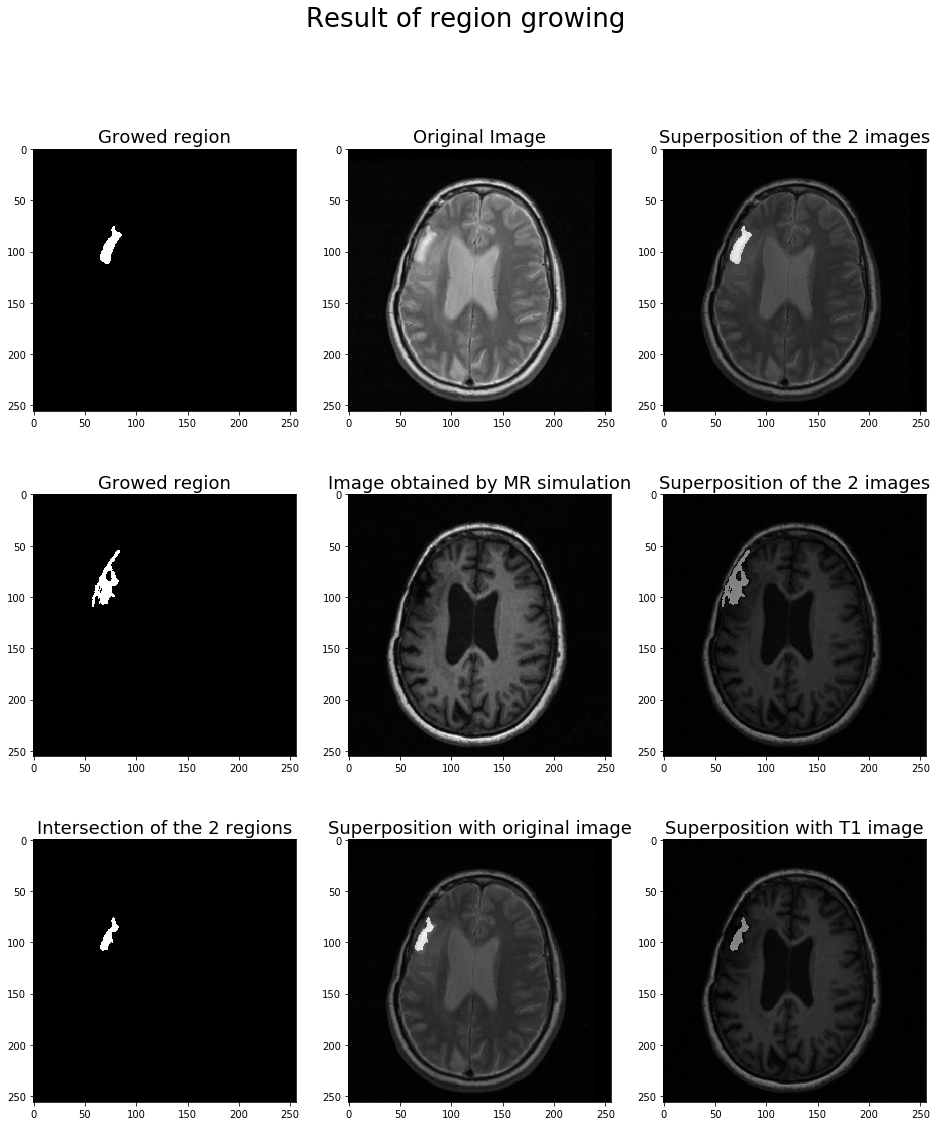

In [ ]:
#Computation of the intersection
bol_growGI = growed_givenImage>0
bol_growMRI = growed_mri>0
intersection = bol_growMRI * bol_growGI

#Plot of the results
fig, axes = plt.subplots(3,3)   
fig.set_size_inches(16,18)
fig.suptitle("Result of region growing",fontsize=26)

axes[0][0].imshow(growed_givenImage,cmap='gray')
axes[0][0].set_title('Growed region',fontsize=18)
axes[0][1].imshow(protonDensityImage,cmap='gray')
axes[0][1].set_title('Original Image',fontsize=18)
axes[0][2].imshow(protonDensityImage,cmap='gray')
axes[0][2].imshow(growed_givenImage,cmap='gray',alpha=0.5)
axes[0][2].set_title('Superposition of the 2 images',fontsize=18)

axes[1][0].imshow(growed_mri,cmap='gray')
axes[1][0].set_title('Growed region',fontsize=18)
axes[1][1].imshow(t1Image,cmap='gray')
axes[1][1].set_title('Image obtained by MR simulation',fontsize=18)
axes[1][2].imshow(t1Image,cmap='gray')
axes[1][2].imshow(growed_mri,cmap='gray',alpha=0.5)
axes[1][2].set_title('Superposition of the 2 images',fontsize=18)

# +rajouter l'intersection des 2 segments
axes[2][0].imshow(intersection,cmap='gray')
axes[2][0].set_title('Intersection of the 2 regions',fontsize=18)
axes[2][1].imshow(protonDensityImage,cmap='gray')
axes[2][1].imshow(intersection,cmap='gray',alpha=0.5)
axes[2][1].set_title('Superposition with original image',fontsize=18)
axes[2][2].imshow(t1Image,cmap='gray')
axes[2][2].imshow(intersection,cmap='gray',alpha=0.5)
axes[2][2].set_title('Superposition with T1 image',fontsize=18)

plt.show()
